In [2]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
sys.path.append(os.path.abspath("../..")) 
from src.training.train import train_autoencoder, train_cellfate
from sklearn.model_selection import train_test_split
from src.models.classifier import mlp_classifier
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from src.preprocessing.preprocessing_functions import augment_dataset, augmentations

# Load brightfield data and trained model

In [7]:
x_train = np.load("/Volumes/InesSeagate/PhotoFate/16Feb/train_images_aug.npy")[:,1]
y_train = np.load("/Volumes/InesSeagate/PhotoFate/16Feb/train_labels_aug.npy")
x_test = np.load("/Volumes/InesSeagate/PhotoFate/16Feb/test_images.npy")[:,1]
y_test = np.load("/Volumes/InesSeagate/PhotoFate/16Feb/test_labels.npy")


In [340]:
x_train__ = np.load("/Volumes/InesSeagate/PhotoFate/16Feb/train_images_aug.npy")[:,0]

(-0.5, 143.5, 143.5, -0.5)

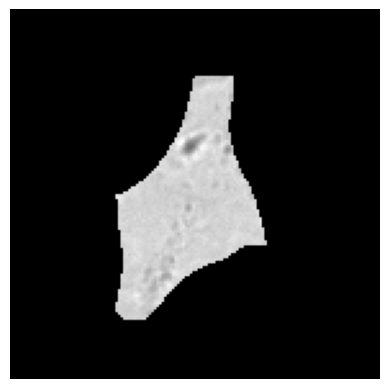

In [346]:
plt.imshow(x_train__[3], cmap="gray") #13
plt.axis("off")

In [362]:
from src.models import Encoder, Decoder, Discriminator, mlp_classifier

config = {
    'seed': 42,
    'latent_dim': 2,
    'GaussianNoise_std': 0.003,
}
epoch = 63
img_shape = (144, 144, 1)
encoder = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model

encoder.load_weights(f"/Users/inescunha/Desktop/AI4CellFate/Rebuttal2/s1_ep100_lr5_la1_seed42_ldim2_s2_lr6_la2_lc1.0_lcon0.2_frame1/models_stage2/encoder_epoch{epoch}.weights.h5") ###TODO: change to the model path
decoder.load_weights(f"/Users/inescunha/Desktop/AI4CellFate/Rebuttal2/s1_ep100_lr5_la1_seed42_ldim2_s2_lr6_la2_lc1.0_lcon0.2_frame1/models_stage2/decoder_epoch{epoch}.weights.h5") ###TODO: change to the model path

# Visualise Latent Space

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step


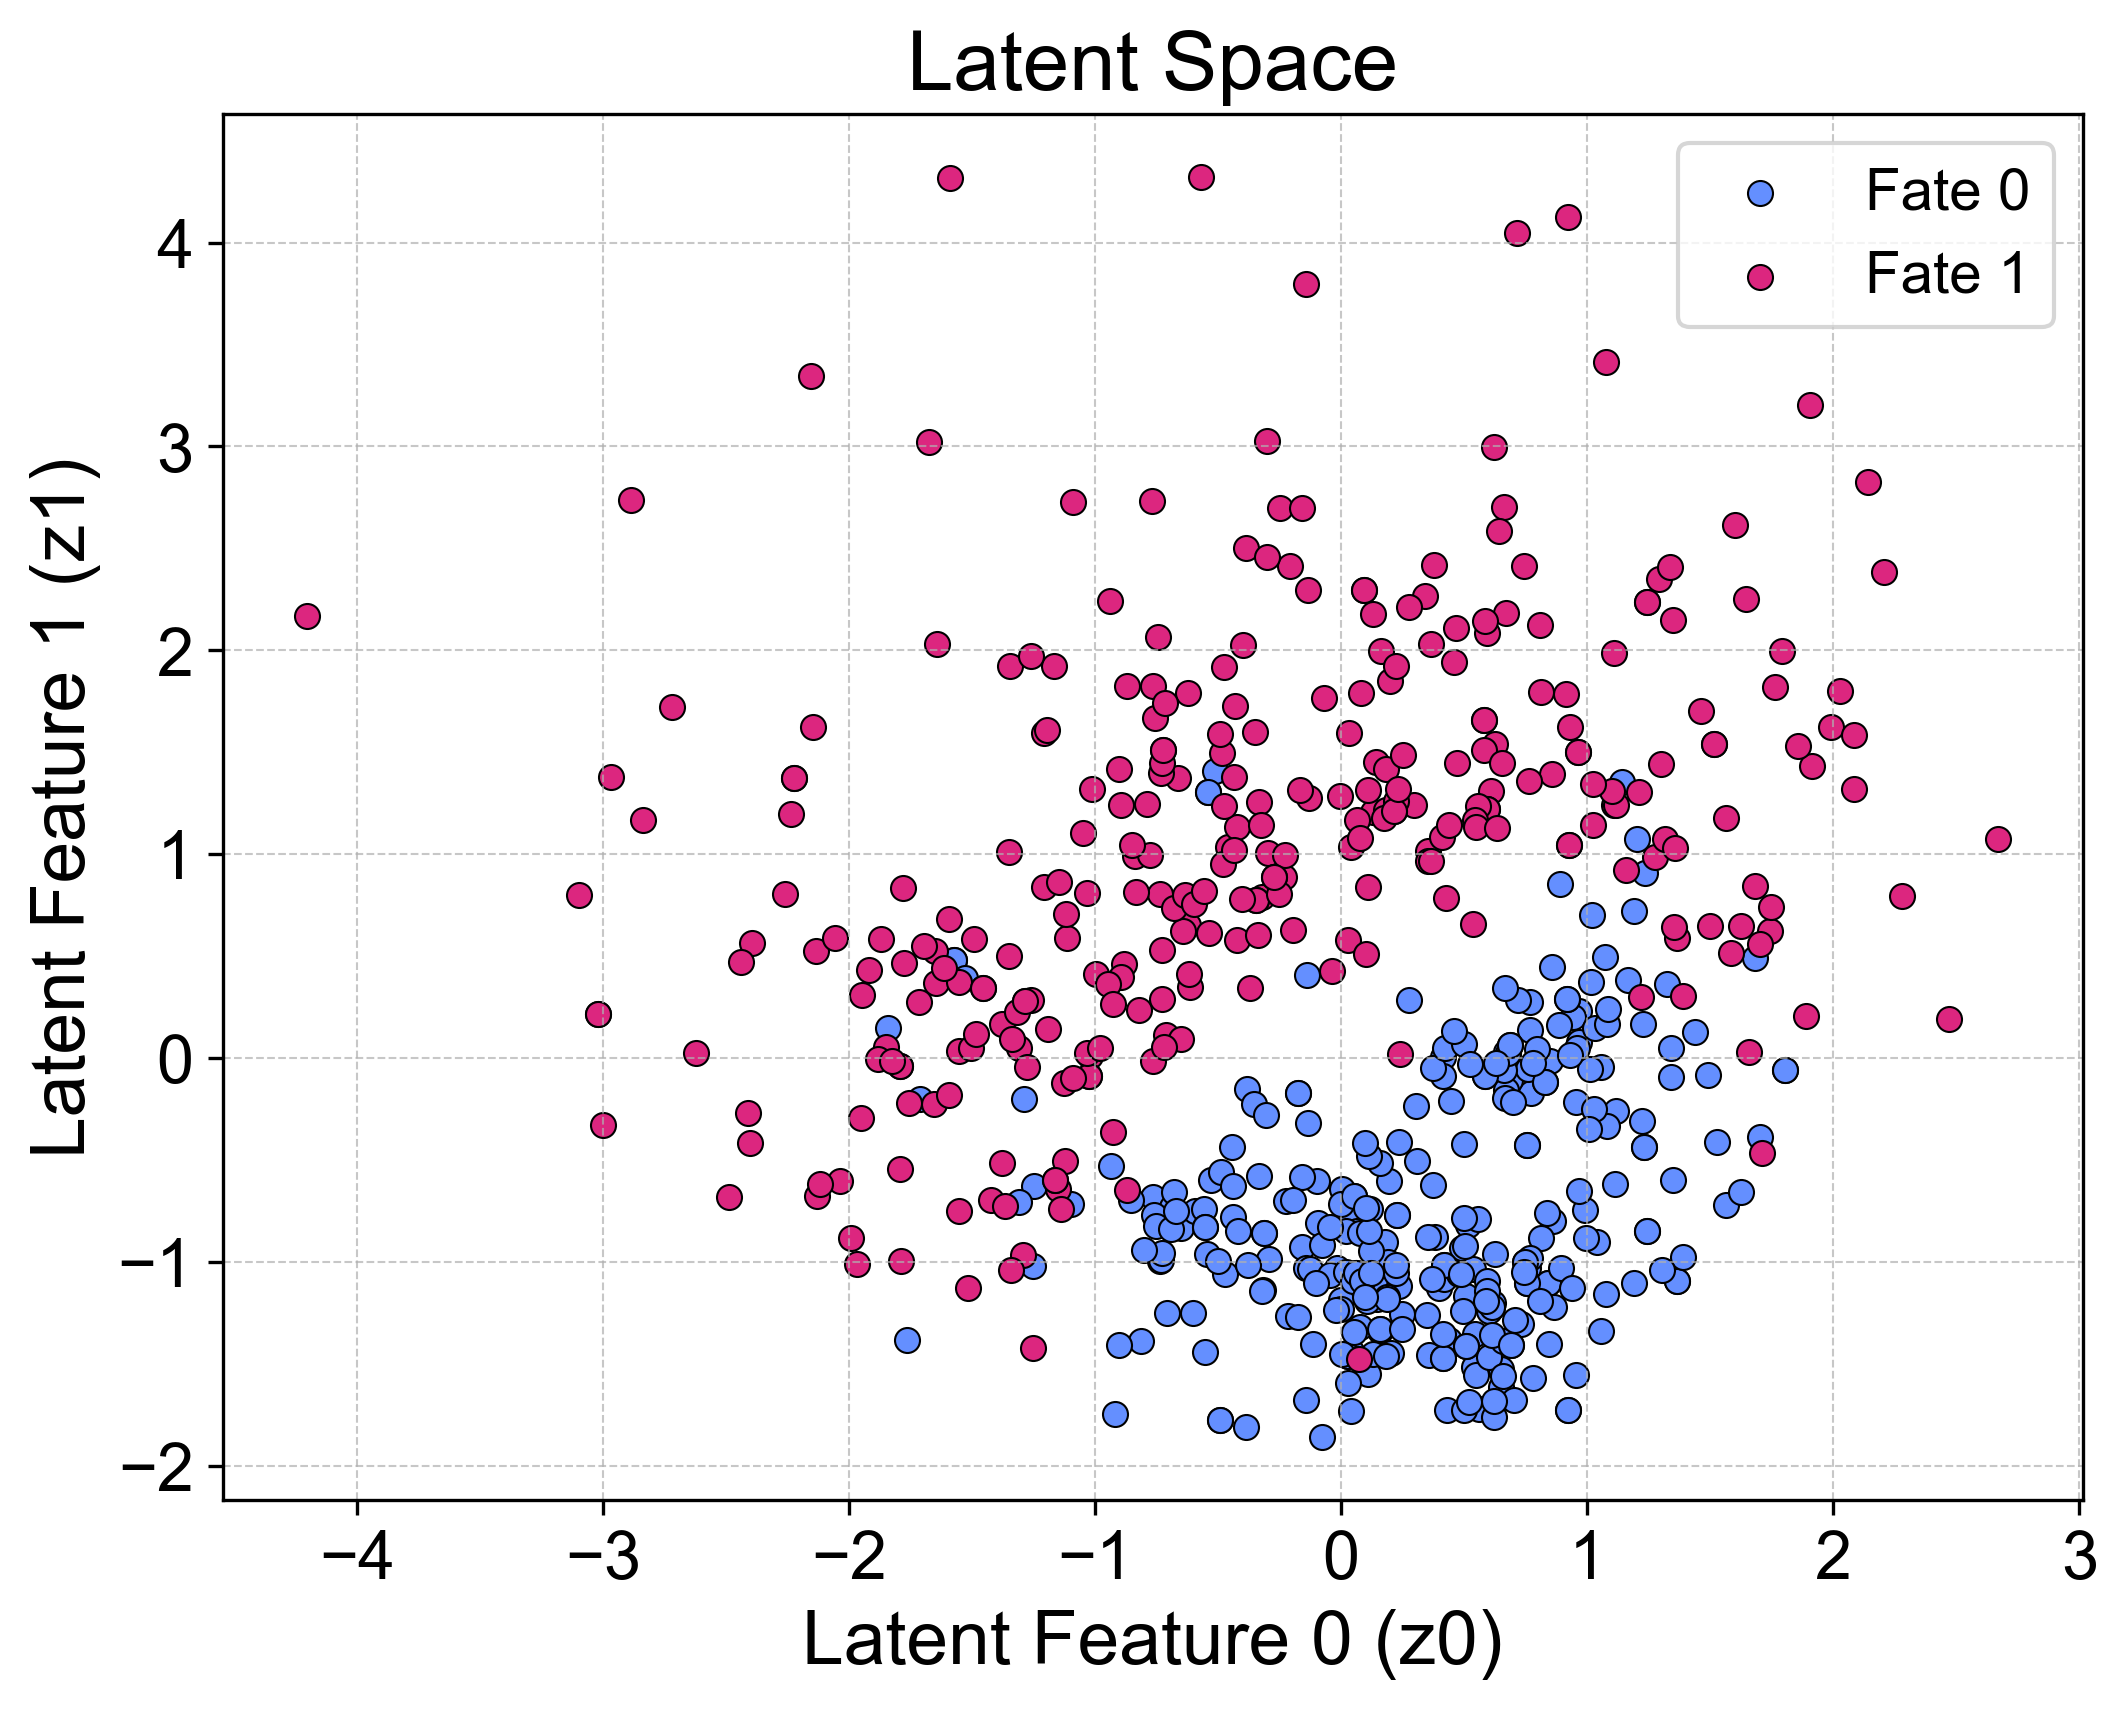

In [363]:
# Predict the latent representations
latent_2d = encoder.predict(x_train) 

# Find extreme points for axis limits
x_min, x_max = latent_2d[:, 0].min() - 0.5, latent_2d[:, 0].max() + 0.5
y_min, y_max = latent_2d[:, 1].min() - 0.5, latent_2d[:, 1].max() + 0.5

# Create the plot
plt.figure(figsize=(8, 6), dpi=300)

# Scatter plot for each class separately with thin gray edges
plt.scatter(latent_2d[y_train == 0][:, 0], latent_2d[y_train == 0][:, 1], 
            color='#648fff', label="Fate 0", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  
plt.scatter(latent_2d[y_train == 1][:, 0], latent_2d[y_train == 1][:, 1], 
            color='#dc267f', label="Fate 1", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  

# Set axis limits
# plt.xlim(-4, 4)
# plt.ylim(-4, 4)

# Make tick labels much bigger and set to Arial font
plt.tick_params(axis='both', which='major', labelsize=16)
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontname('Arial')

# Increase font size and set Arial font
plt.xlabel("Latent Feature 0 (z0)", fontsize=18, fontname="Arial")
plt.ylabel("Latent Feature 1 (z1)", fontsize=18, fontname="Arial")
plt.title("Latent Space", fontsize=20, fontname="Arial")

# Legend and grid
plt.legend(fontsize=14)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

#plt.savefig("brightfield_latent_space.eps", format="eps", dpi=600, bbox_inches="tight")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


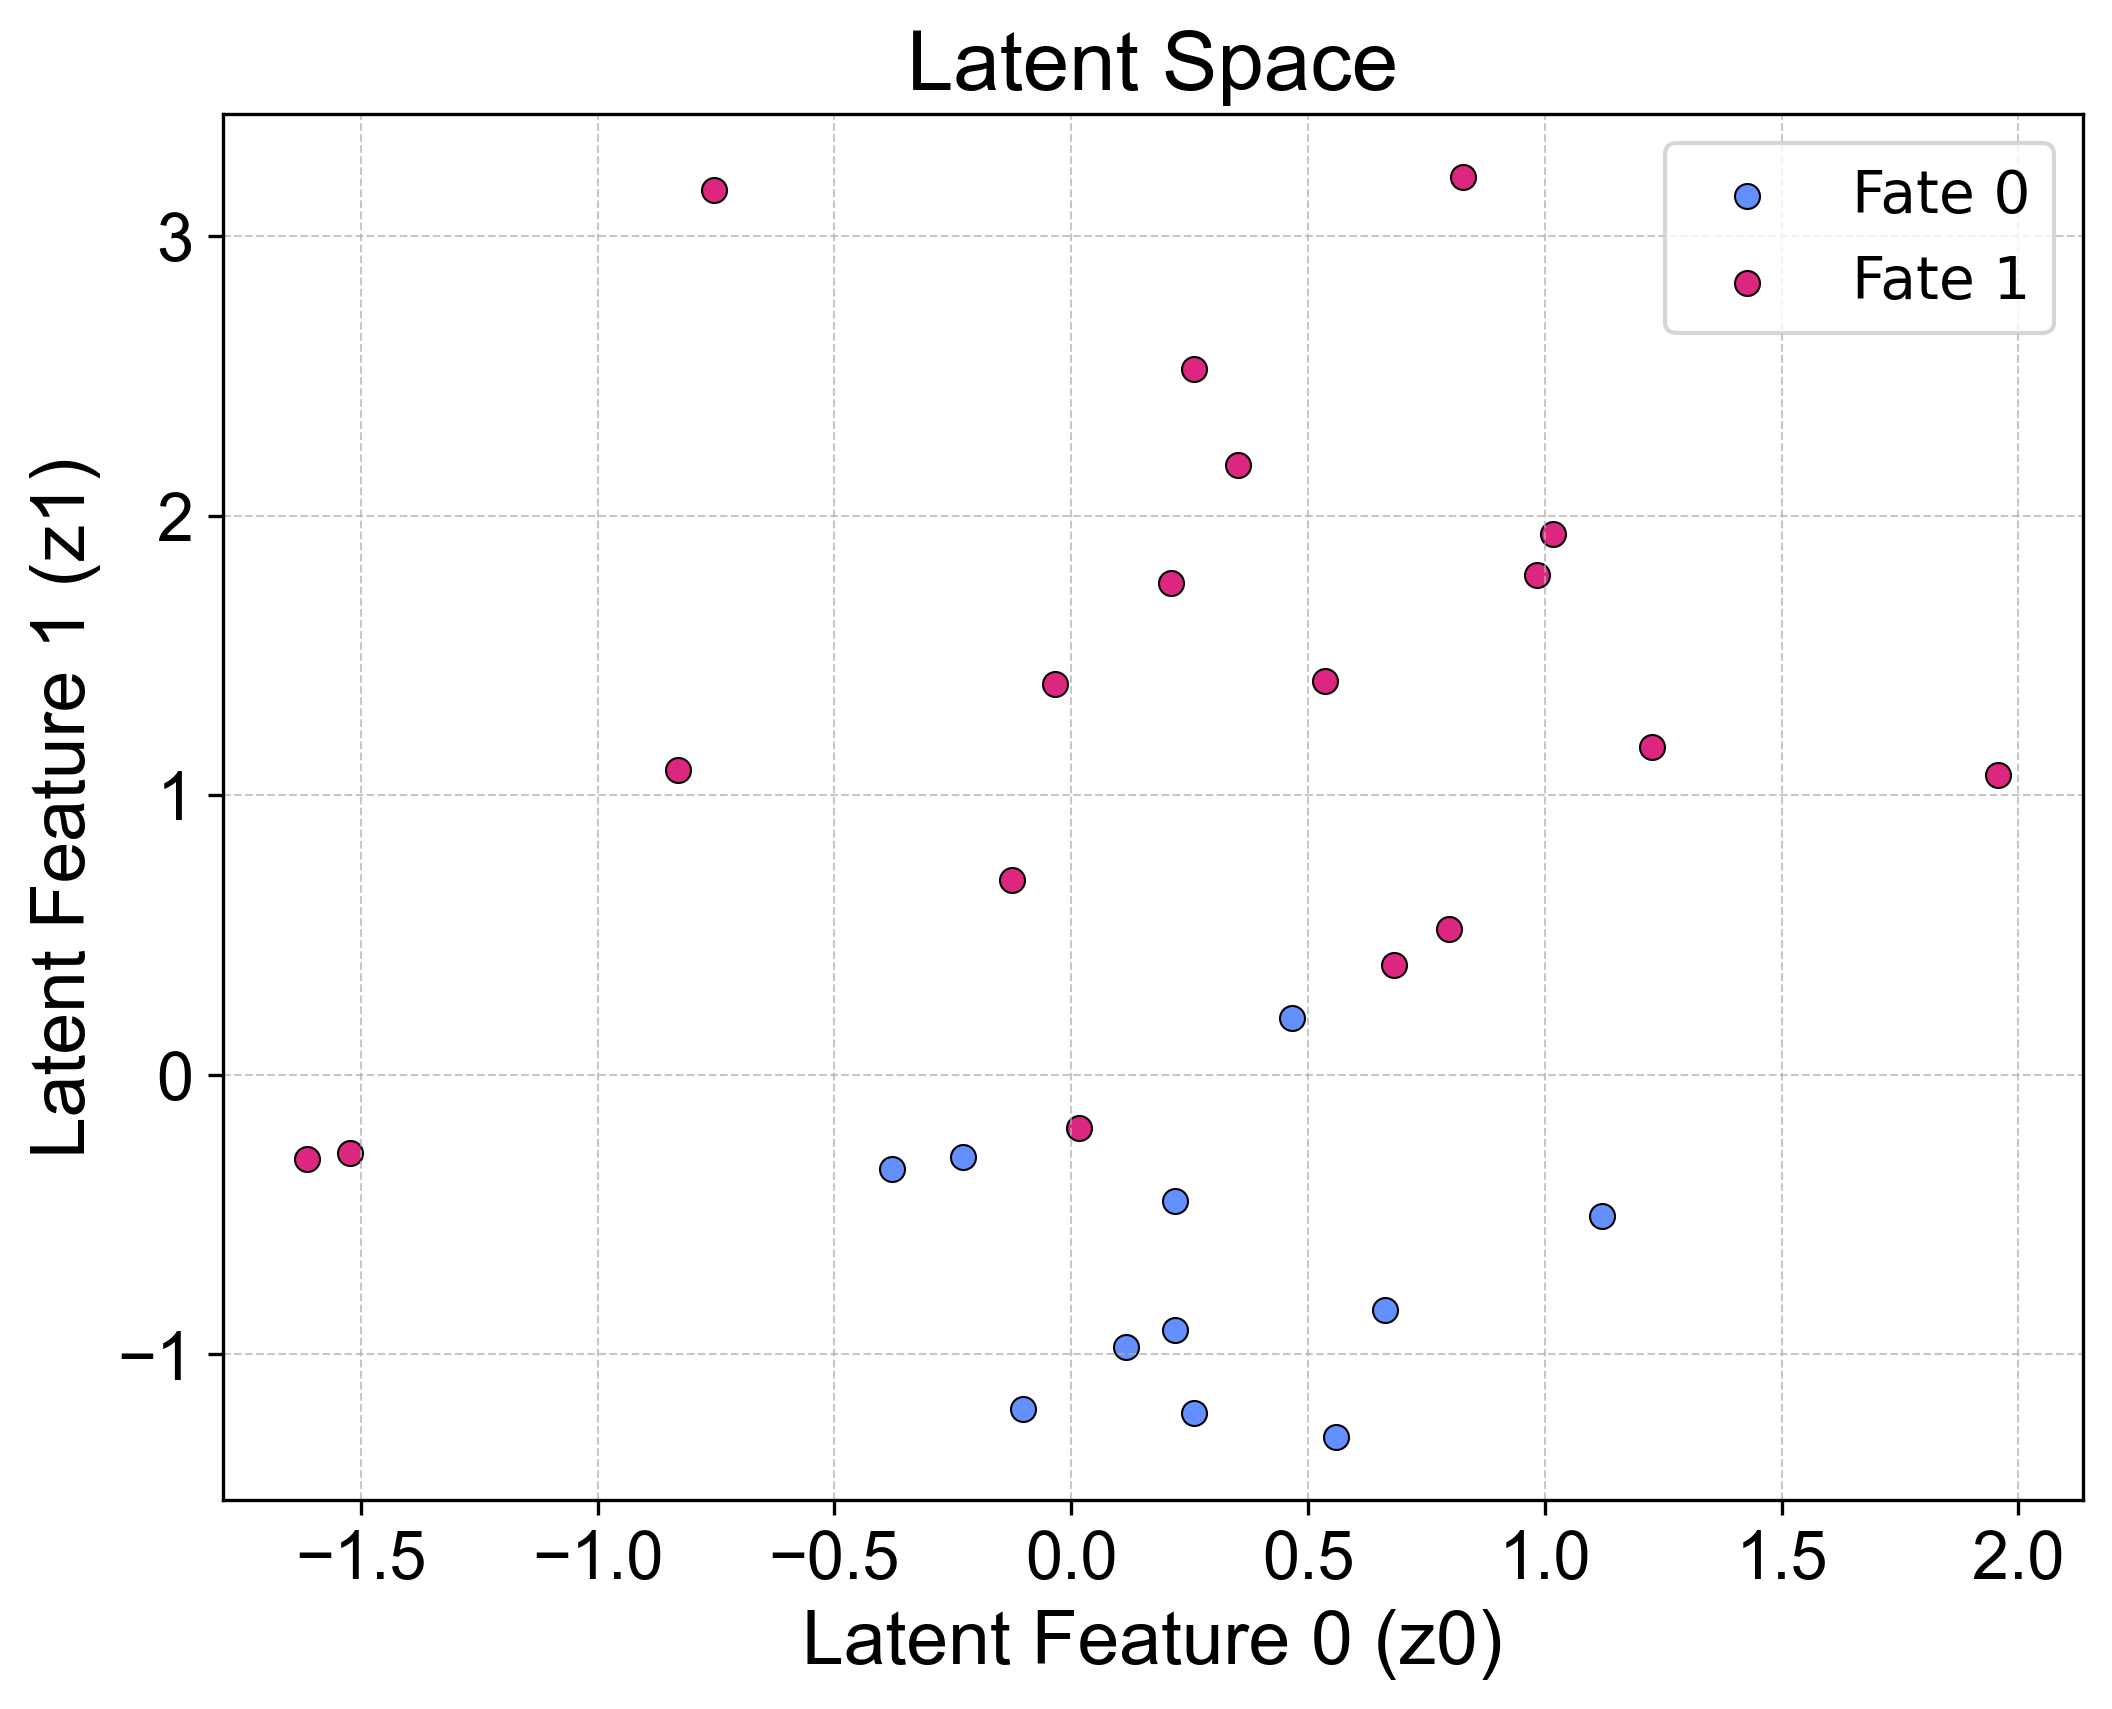

In [251]:
# Predict the latent representations
latent_2d = encoder.predict(x_test)  # Shape (1380, 2)

# Find extreme points for axis limits
x_min, x_max = latent_2d[:, 0].min() - 0.5, latent_2d[:, 0].max() + 0.5
y_min, y_max = latent_2d[:, 1].min() - 0.5, latent_2d[:, 1].max() + 0.5

# Create the plot
plt.figure(figsize=(8, 6), dpi=300)

# Scatter plot for each class separately with thin gray edges
plt.scatter(latent_2d[y_test == 0][:, 0], latent_2d[y_test == 0][:, 1], 
            color='#648fff', label="Fate 0", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  
plt.scatter(latent_2d[y_test == 1][:, 0], latent_2d[y_test == 1][:, 1], 
            color='#dc267f', label="Fate 1", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  

# Set axis limits
# plt.xlim(-3, 4)
# plt.ylim(-3.5, 2)

# Increase font size and set Arial font
plt.xlabel("Latent Feature 0 (z0)", fontsize=18, fontname="Arial")
plt.ylabel("Latent Feature 1 (z1)", fontsize=18, fontname="Arial")
plt.title("Latent Space", fontsize=20, fontname="Arial")

# Make tick labels much bigger and set to Arial font
plt.tick_params(axis='both', which='major', labelsize=16)
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontname('Arial')

# Legend and grid
plt.legend(fontsize=14)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

#plt.savefig("test_ls_noaug.eps", format="eps", dpi=600, bbox_inches="tight")
plt.show()

# Classify from the Latent Space

In [298]:
config_clf = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
    'latent_dim': 2,
}

tf.keras.utils.set_random_seed(config_clf['seed'])

classifier = mlp_classifier(latent_dim=config_clf['latent_dim']) 

# Train the classifier
classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config_clf['learning_rate']), metrics=['accuracy'])
classifier.summary()

history = classifier.fit(encoder.predict(x_train), y_train, batch_size=config_clf['batch_size'], epochs=config_clf['epochs'], validation_data=(encoder.predict(x_test), y_test)) 

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_93 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5570 - loss: 0.7122 - val_accuracy: 0.4828 - val_loss: 0.8273
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5942 - loss: 0.7053 - val_accuracy: 0.4828 - val_loss: 0.7957
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7162 - loss: 0.6711 - val_accuracy: 0.4828 - val_loss: 0.7655
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.7093 - loss: 0.6682 - val_accuracy: 0.5172 - val_loss: 0.7364
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.7192 - loss: 0.6327 - val_accuracy: 0.5862 - val_loss: 0.7098
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - accuracy: 0.7233 - loss: 0.6163 - val_accuracy: 0.6207 - val_loss: 0.6858
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.7403 - loss: 0.6034 - val_accuracy: 0.6207 - val_loss: 0.6644
Epoch 8/50
21/21 ━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[1.         0.        ]
 [0.16666667 0.83333333]]


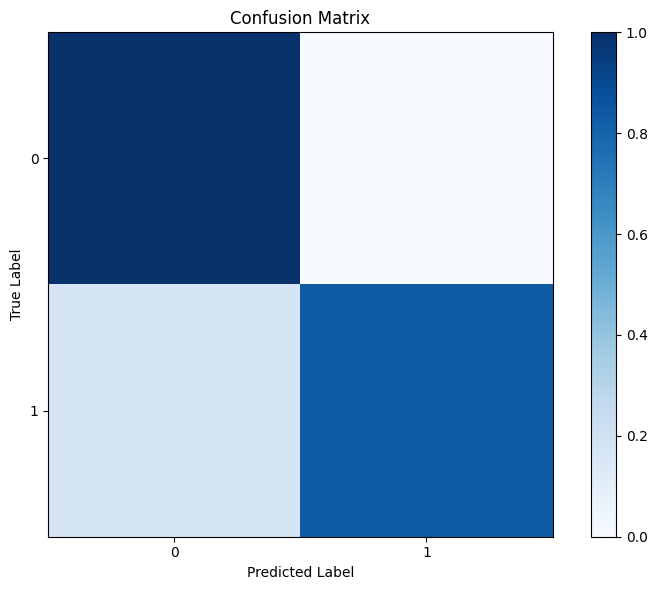

In [299]:
num_classes = len(np.unique(y_train))
y_pred = classifier.predict(encoder.predict(x_test))
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)

class_sums = conf_mat.sum(axis=1, keepdims=True)
conf_matrix_normalized = conf_mat / class_sums

print(conf_matrix_normalized)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

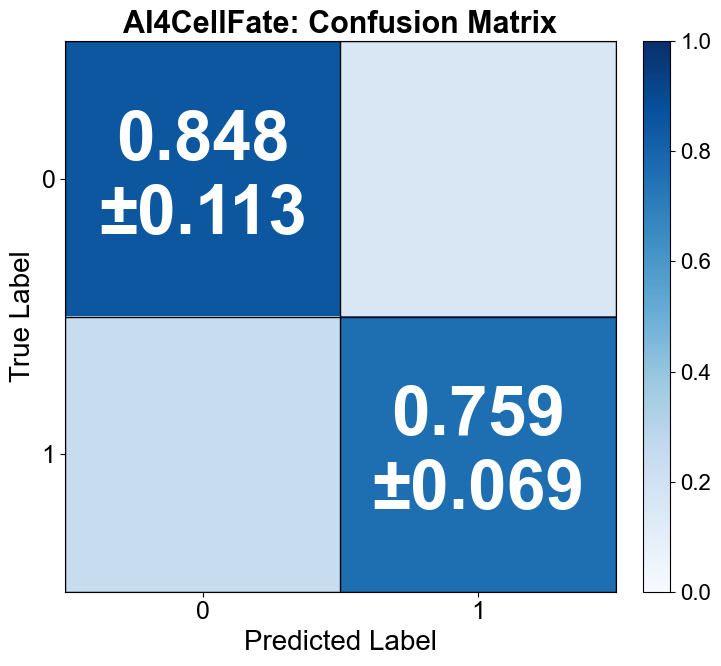

In [ ]:
ai4cellfate_seed42 = np.load("/Users/inescunha/Desktop/AI4CellFate/Rebuttal2/s1_ep100_lr5_la1_seed42_ldim2_s2_lr6_la2_lc1.0_lcon0.2_frame1/confusion_matrix_values_epoch_63.npy")
ai4cellfate_seed43 = np.load("/Users/inescunha/Desktop/AI4CellFate/Rebuttal2/s1_ep100_lr5_la1_seed43_ldim2_s2_lr6_la2_lc1_lcon0.2/confusion_matrix_values_epoch_66.npy")
ai4cellfate_seed44 = np.load("/Users/inescunha/Desktop/AI4CellFate/Rebuttal2/s1_ep100_lr5_la1_seed44_ldim2_s2_lr6_la2_lc1_lcon0.2/confusion_matrix_values_epoch_64.npy")

conf_matrix_ai4cellfate = np.stack([ai4cellfate_seed42, ai4cellfate_seed43, ai4cellfate_seed44], axis=0)

# Compute mean and std across seeds
mean_cm = np.mean(conf_matrix_ai4cellfate, axis=0)
std_cm = np.std(conf_matrix_ai4cellfate, axis=0)

# Use Arial and larger fonts
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 18

fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(mean_cm, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)

# Title and labels
ax.set_title('AI4CellFate: Confusion Matrix', fontsize=22, fontweight='bold')
num_classes = mean_cm.shape[0]
ax.set_xlabel('Predicted Label', fontsize=20)
ax.set_ylabel('True Label', fontsize=20)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels([str(i) for i in range(num_classes)], fontsize=18)
ax.set_yticklabels([str(i) for i in range(num_classes)], fontsize=18)

# Grid lines for clarity
ax.set_xticks(np.arange(-0.5, num_classes, 1), minor=True)
ax.set_yticks(np.arange(-0.5, num_classes, 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
ax.tick_params(which='minor', bottom=False, left=False)

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=16)

# Annotate ONLY diagonal cells with mean ± std in WHITE
for i in range(num_classes):
    for j in range(num_classes):
        if i == j:  # Only show values on the diagonal
            text = f"{mean_cm[i, j]:.3f}\n±{std_cm[i, j]:.3f}"
            ax.text(j, i, text, ha='center', va='center', color='white', fontsize=50, fontweight='bold')

plt.tight_layout()
#plt.savefig("brightfield_conf_matrix.eps", dpi=300, bbox_inches="tight")
plt.show()

In [360]:
ai4cellfate_seed42

array([[0.72727273, 0.27272727],
       [0.22222222, 0.77777778]])

# Visual Interpretation

(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


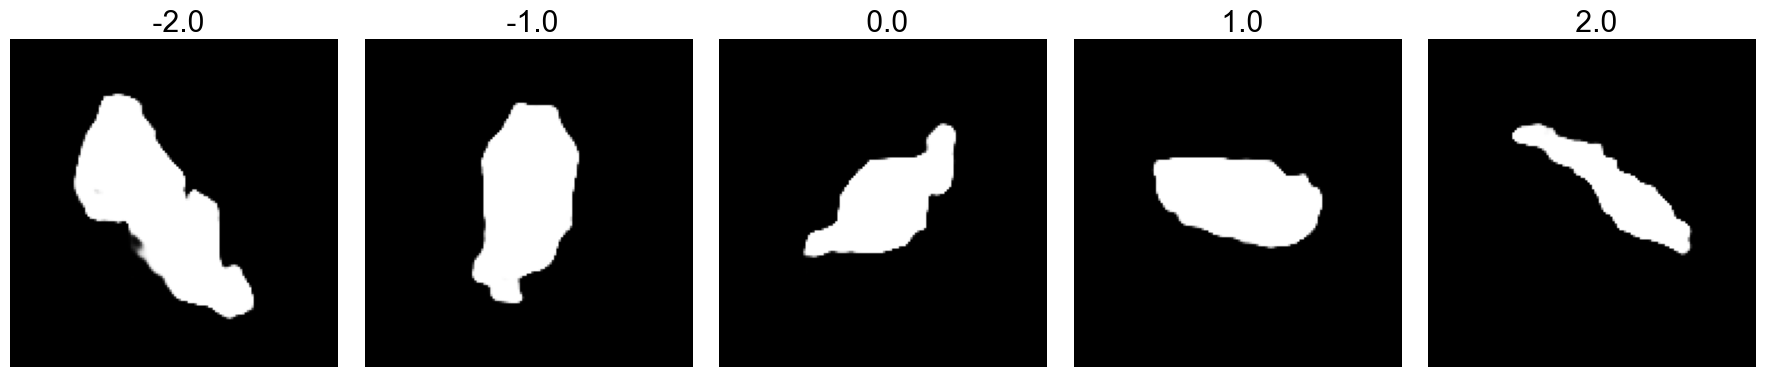

In [408]:
baseline_latent_vector = np.zeros((2, 2), dtype=np.float32)  # Start with a neutral latent vector

# Choose the feature to perturb (e.g., feature 0)
feature_index = 0

# Perturbation range
perturbations = np.linspace(-1.4, 2.1, 5) # feature index 1
perturbations = np.linspace(-2, 2, 5) # feature index 0

# Store the perturbed reconstructions
perturbed_reconstructions = []

for value in perturbations:
    # Create a copy of the baseline latent vector
    perturbed_vector = baseline_latent_vector.copy()
    print(perturbed_vector.shape)
    # Modify the selected feature
    perturbed_vector[0, feature_index] = value
    
    # Decode the perturbed vector to generate a synthetic image
    synthetic_image = decoder.predict(perturbed_vector)  # Assuming 'decoder' is your trained decoder model
    
    # Store the result
    perturbed_reconstructions.append(synthetic_image[0])  # Assuming decoder outputs (batch_size, height, width, channels)

# Convert list to numpy array for easier handling
perturbed_reconstructions = np.array(perturbed_reconstructions)

# Plot the results
fig, axs = plt.subplots(1, 5, figsize=(18, 4))
vmin = perturbed_reconstructions.min()
vmax = perturbed_reconstructions.max()

for i in range(5):
    im = axs[i].imshow(perturbed_reconstructions[i, :, :, 0], cmap='gray', vmin=0.0, vmax=vmax)
    axs[i].set_title(f' {perturbations[i]}')
    axs[i].axis('off')
    #fig.colorbar(im, ax=axs[i])

plt.tight_layout()
#plt.savefig("perturbations_feat1.eps", format="eps", dpi=300, bbox_inches="tight")
plt.show()


(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


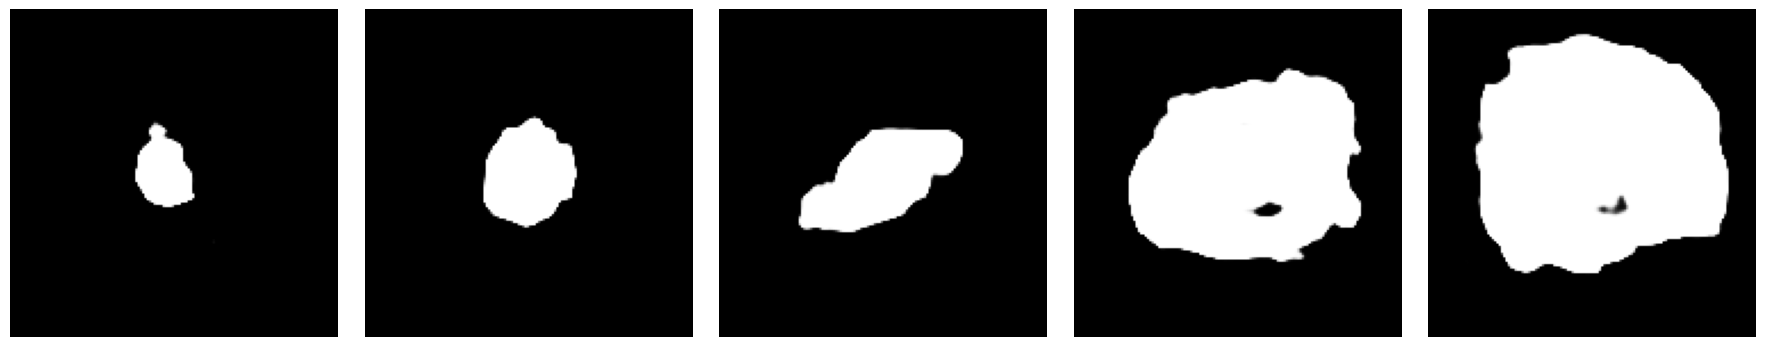

In [403]:
baseline_latent_vector = np.zeros((2, 2), dtype=np.float32)  # Start with a neutral latent vector

# Choose the feature to perturb (e.g., feature 0)
feature_index = 1

# Perturbation range
#perturbations = np.linspace(-1.75, 3, 5) 
perturbations = np.array([-1.75, -0.75,  0.75,  2,  3.  ])
# Store the perturbed reconstructions
perturbed_reconstructions = []

for value in perturbations:
    # Create a copy of the baseline latent vector
    perturbed_vector = baseline_latent_vector.copy()
    print(perturbed_vector.shape)
    # Modify the selected feature
    perturbed_vector[0, feature_index] = value
    
    # Decode the perturbed vector to generate a synthetic image
    synthetic_image = decoder.predict(perturbed_vector)  # Assuming 'decoder' is your trained decoder model
    
    # Store the result
    perturbed_reconstructions.append(synthetic_image[0])  # Assuming decoder outputs (batch_size, height, width, channels)

# Convert list to numpy array for easier handling
perturbed_reconstructions = np.array(perturbed_reconstructions)

# Plot the results
fig, axs = plt.subplots(1, 5, figsize=(18, 4))
vmin = perturbed_reconstructions.min()
vmax = perturbed_reconstructions.max()

for i in range(5):
    im = axs[i].imshow(perturbed_reconstructions[i, :, :, 0], cmap='gray', vmin=0.0, vmax=vmax)
    #axs[i].set_title(f' {perturbations[i]}')
    axs[i].axis('off')
    #fig.colorbar(im, ax=axs[i])

plt.tight_layout()
#plt.savefig("perturbations_feat1.eps", format="eps", dpi=300, bbox_inches="tight")
plt.show()


# Feature Extraction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


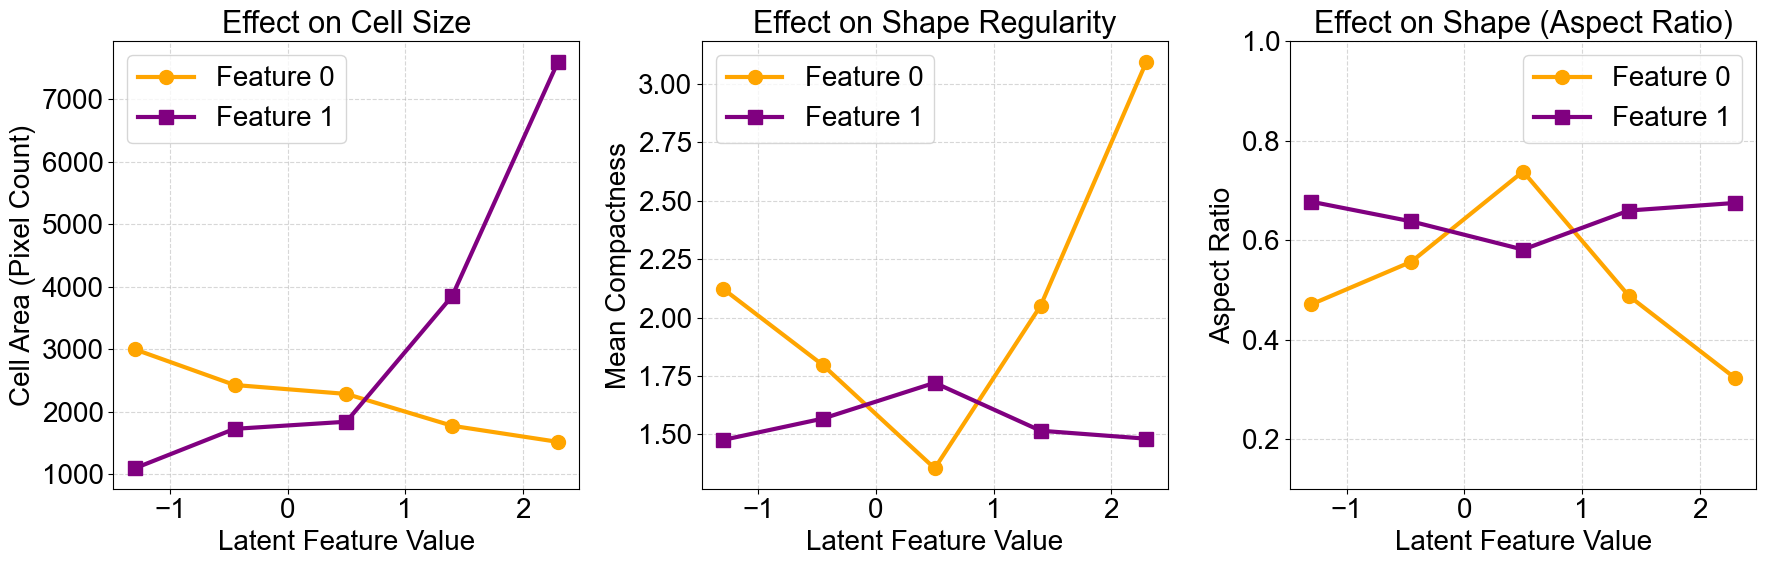

In [ ]:
import cv2

# Initialize arrays to store feature effects
areas_0, areas_1 = [], []
intensities_0, intensities_1 = [], []
aspect_ratios_0, aspect_ratios_1 = [], []
circularities_0, circularities_1 = [], []
compactnesses_0, compactnesses_1 = [], []
# Function to compute cell area
def compute_area(image, threshold=0.1):
    return np.sum(image > threshold)

# def compute_intensity(image):
#     return np.max(image)

# Function to compute intensity at the center of the image
def compute_intensity(image):
    return image[image.shape[0]//2][image.shape[0]//2]


def compute_compactness(image, threshold=0.1):
    """
    Compute compactness as perimeter^2 / (4*pi*area).
    Values close to 1 indicate circular shapes, higher values indicate irregular shapes.
    """
    binary = (image > threshold).astype(np.uint8)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return 1.0  # Default to circular
    
    cnt = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    
    if area <= 0:
        return 1.0
    
    compactness = (perimeter**2) / (4 * np.pi * area + 1e-6)
    return compactness

def compute_granularity(image, threshold=0.1):
    """
    Compute granularity using local standard deviation as a texture measure.
    Higher values indicate more granular/textured regions.
    """
    from scipy import ndimage
    
    # Apply threshold to focus on cell region
    cell_region = image > threshold
    if np.sum(cell_region) == 0:
        return 0.0
    
    # Compute local standard deviation using a 3x3 kernel
    local_mean = ndimage.uniform_filter(image.astype(float), size=3)
    local_sqr_mean = ndimage.uniform_filter(image.astype(float)**2, size=3)
    local_var = local_sqr_mean - local_mean**2
    local_std = np.sqrt(np.maximum(local_var, 0))
    
    # Average standard deviation in cell region (granularity measure)
    granularity = np.mean(local_std[cell_region])
    return granularity

# Function to compute shape descriptors (aspect ratio, circularity)
def compute_shape_features(image, threshold=0.1):
    binary = (image > threshold).astype(np.uint8)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return 0, 0  
    
    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / h
    
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    circularity = 4 * np.pi * (area / (perimeter ** 2 + 1e-6))  # Avoid division by zero
    
    return aspect_ratio, circularity

# Perturbation values
#perturbations = np.array([-2, -0.5, 0.3, 1.5, 2.4])
perturbations = np.linspace(-1.3, 2.0, 5)
#perturbations = np.array([-1.3, -0.3,  0.6,  1.4,  2.3])
perturbations = np.array([-1.30, -0.45,  0.50,  1.40,  2.30])
# Iterate over both latent features
for feature_index in [0, 1]:
    for value in perturbations:
        # Create perturbed latent vector
        perturbed_vector = np.zeros((2, 2), dtype=np.float32)
        perturbed_vector[0, feature_index] = value

        # Decode the perturbed vector to generate a synthetic image
        synthetic_image = decoder.predict(perturbed_vector)[0, :, :, 0]

        # Compute features
        area = compute_area(synthetic_image)
        intensity = compute_intensity(synthetic_image)
        aspect_ratio, circularity = compute_shape_features(synthetic_image)
        compactness = compute_compactness(synthetic_image)

        # Store results based on the feature being perturbed
        if feature_index == 0:
            areas_0.append(area)
            intensities_0.append(intensity)
            aspect_ratios_0.append(aspect_ratio)
            circularities_0.append(circularity)
            compactnesses_0.append(compactness)
        else:
            areas_1.append(area)
            intensities_1.append(intensity)
            aspect_ratios_1.append(aspect_ratio)
            circularities_1.append(circularity)
            compactnesses_1.append(compactness)

# Define colors
# color_0 = "#E69F00"  # Orange
# color_1 = "#009E73"  # Teal
color_0 = "orange"
color_1 = "purple"

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Cell Area
axs[0].plot(perturbations, areas_0, marker='o', color=color_0, markersize=10, linewidth=3, label="Feature 0")
axs[0].plot(perturbations, areas_1, marker='s', color=color_1, markersize=10, linewidth=3, label="Feature 1")
axs[0].set_xlabel("Latent Feature Value", fontsize=20, fontname="Arial")
axs[0].set_ylabel("Cell Area (Pixel Count)", fontsize=20, fontname="Arial")
axs[0].set_title("Effect on Cell Size", fontsize=22, fontname="Arial")
axs[0].legend(fontsize=20)
axs[0].grid(True, linestyle="--", alpha=0.5)
axs[0].tick_params(axis='both', which='major', labelsize=20)  # Make tick labels much bigger
for label in axs[0].get_xticklabels() + axs[0].get_yticklabels():
    label.set_fontname('Arial')

# Plot Mean Compactness
axs[1].plot(perturbations, compactnesses_0, marker='o', color=color_0, markersize=10, linewidth=3, label="Feature 0")
axs[1].plot(perturbations, compactnesses_1, marker='s', color=color_1, markersize=10, linewidth=3, label="Feature 1")
axs[1].set_xlabel("Latent Feature Value", fontsize=20, fontname="Arial")
axs[1].set_ylabel("Mean Compactness", fontsize=20, fontname="Arial")
axs[1].set_title("Effect on Shape Regularity", fontsize=22, fontname="Arial")
axs[1].legend(fontsize=20)
axs[1].grid(True, linestyle="--", alpha=0.5)
axs[1].tick_params(axis='both', which='major', labelsize=20)  # Make tick labels much bigger
for label in axs[1].get_xticklabels() + axs[1].get_yticklabels():
    label.set_fontname('Arial')

# Plot Shape Descriptors (Aspect Ratio)
axs[2].plot(perturbations, circularities_0, marker='o', color=color_0, markersize=10, linewidth=3, label="Feature 0")
axs[2].plot(perturbations, circularities_1, marker='s', color=color_1, markersize=10, linewidth=3, label="Feature 1")
axs[2].set_xlabel("Latent Feature Value", fontsize=20, fontname="Arial")
axs[2].set_ylabel("Aspect Ratio", fontsize=20, fontname="Arial")
axs[2].set_title("Effect on Shape (Aspect Ratio)", fontsize=22, fontname="Arial")
axs[2].set_ylim(0.1, 1.0)
axs[2].legend(fontsize=20)
axs[2].grid(True, linestyle="--", alpha=0.5)
axs[2].tick_params(axis='both', which='major', labelsize=20)  # Make tick labels much bigger
for label in axs[2].get_xticklabels() + axs[2].get_yticklabels():
    label.set_fontname('Arial')

# Adjust layout and save as high-quality images
plt.tight_layout()
#plt.savefig("feature_effects.eps", format="eps", bbox_inches="tight")

plt.show()

# Non-engineered Latent Space

In [352]:
from src.models import Encoder, Decoder, Discriminator, mlp_classifier

config = {
    'seed': 42,
    'latent_dim': 2,
    'GaussianNoise_std': 0.003,
}
epoch = 63
img_shape = (144, 144, 1)
encoder = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model

encoder.load_weights(f"/Users/inescunha/Desktop/AI4CellFate/Rebuttal2/ablation_study/s1_ep100_lr5_la1_seed42_ldim2_s2_lr6_la2_lc0.0_lcon0.0_frame1/models_stage2/encoder_epoch{epoch}.weights.h5") ###TODO: change to the model path
decoder.load_weights(f"/Users/inescunha/Desktop/AI4CellFate/Rebuttal2/ablation_study/s1_ep100_lr5_la1_seed42_ldim2_s2_lr6_la2_lc0.0_lcon0.0_frame1/models_stage2/decoder_epoch{epoch}.weights.h5") ###TODO: change to the model path

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


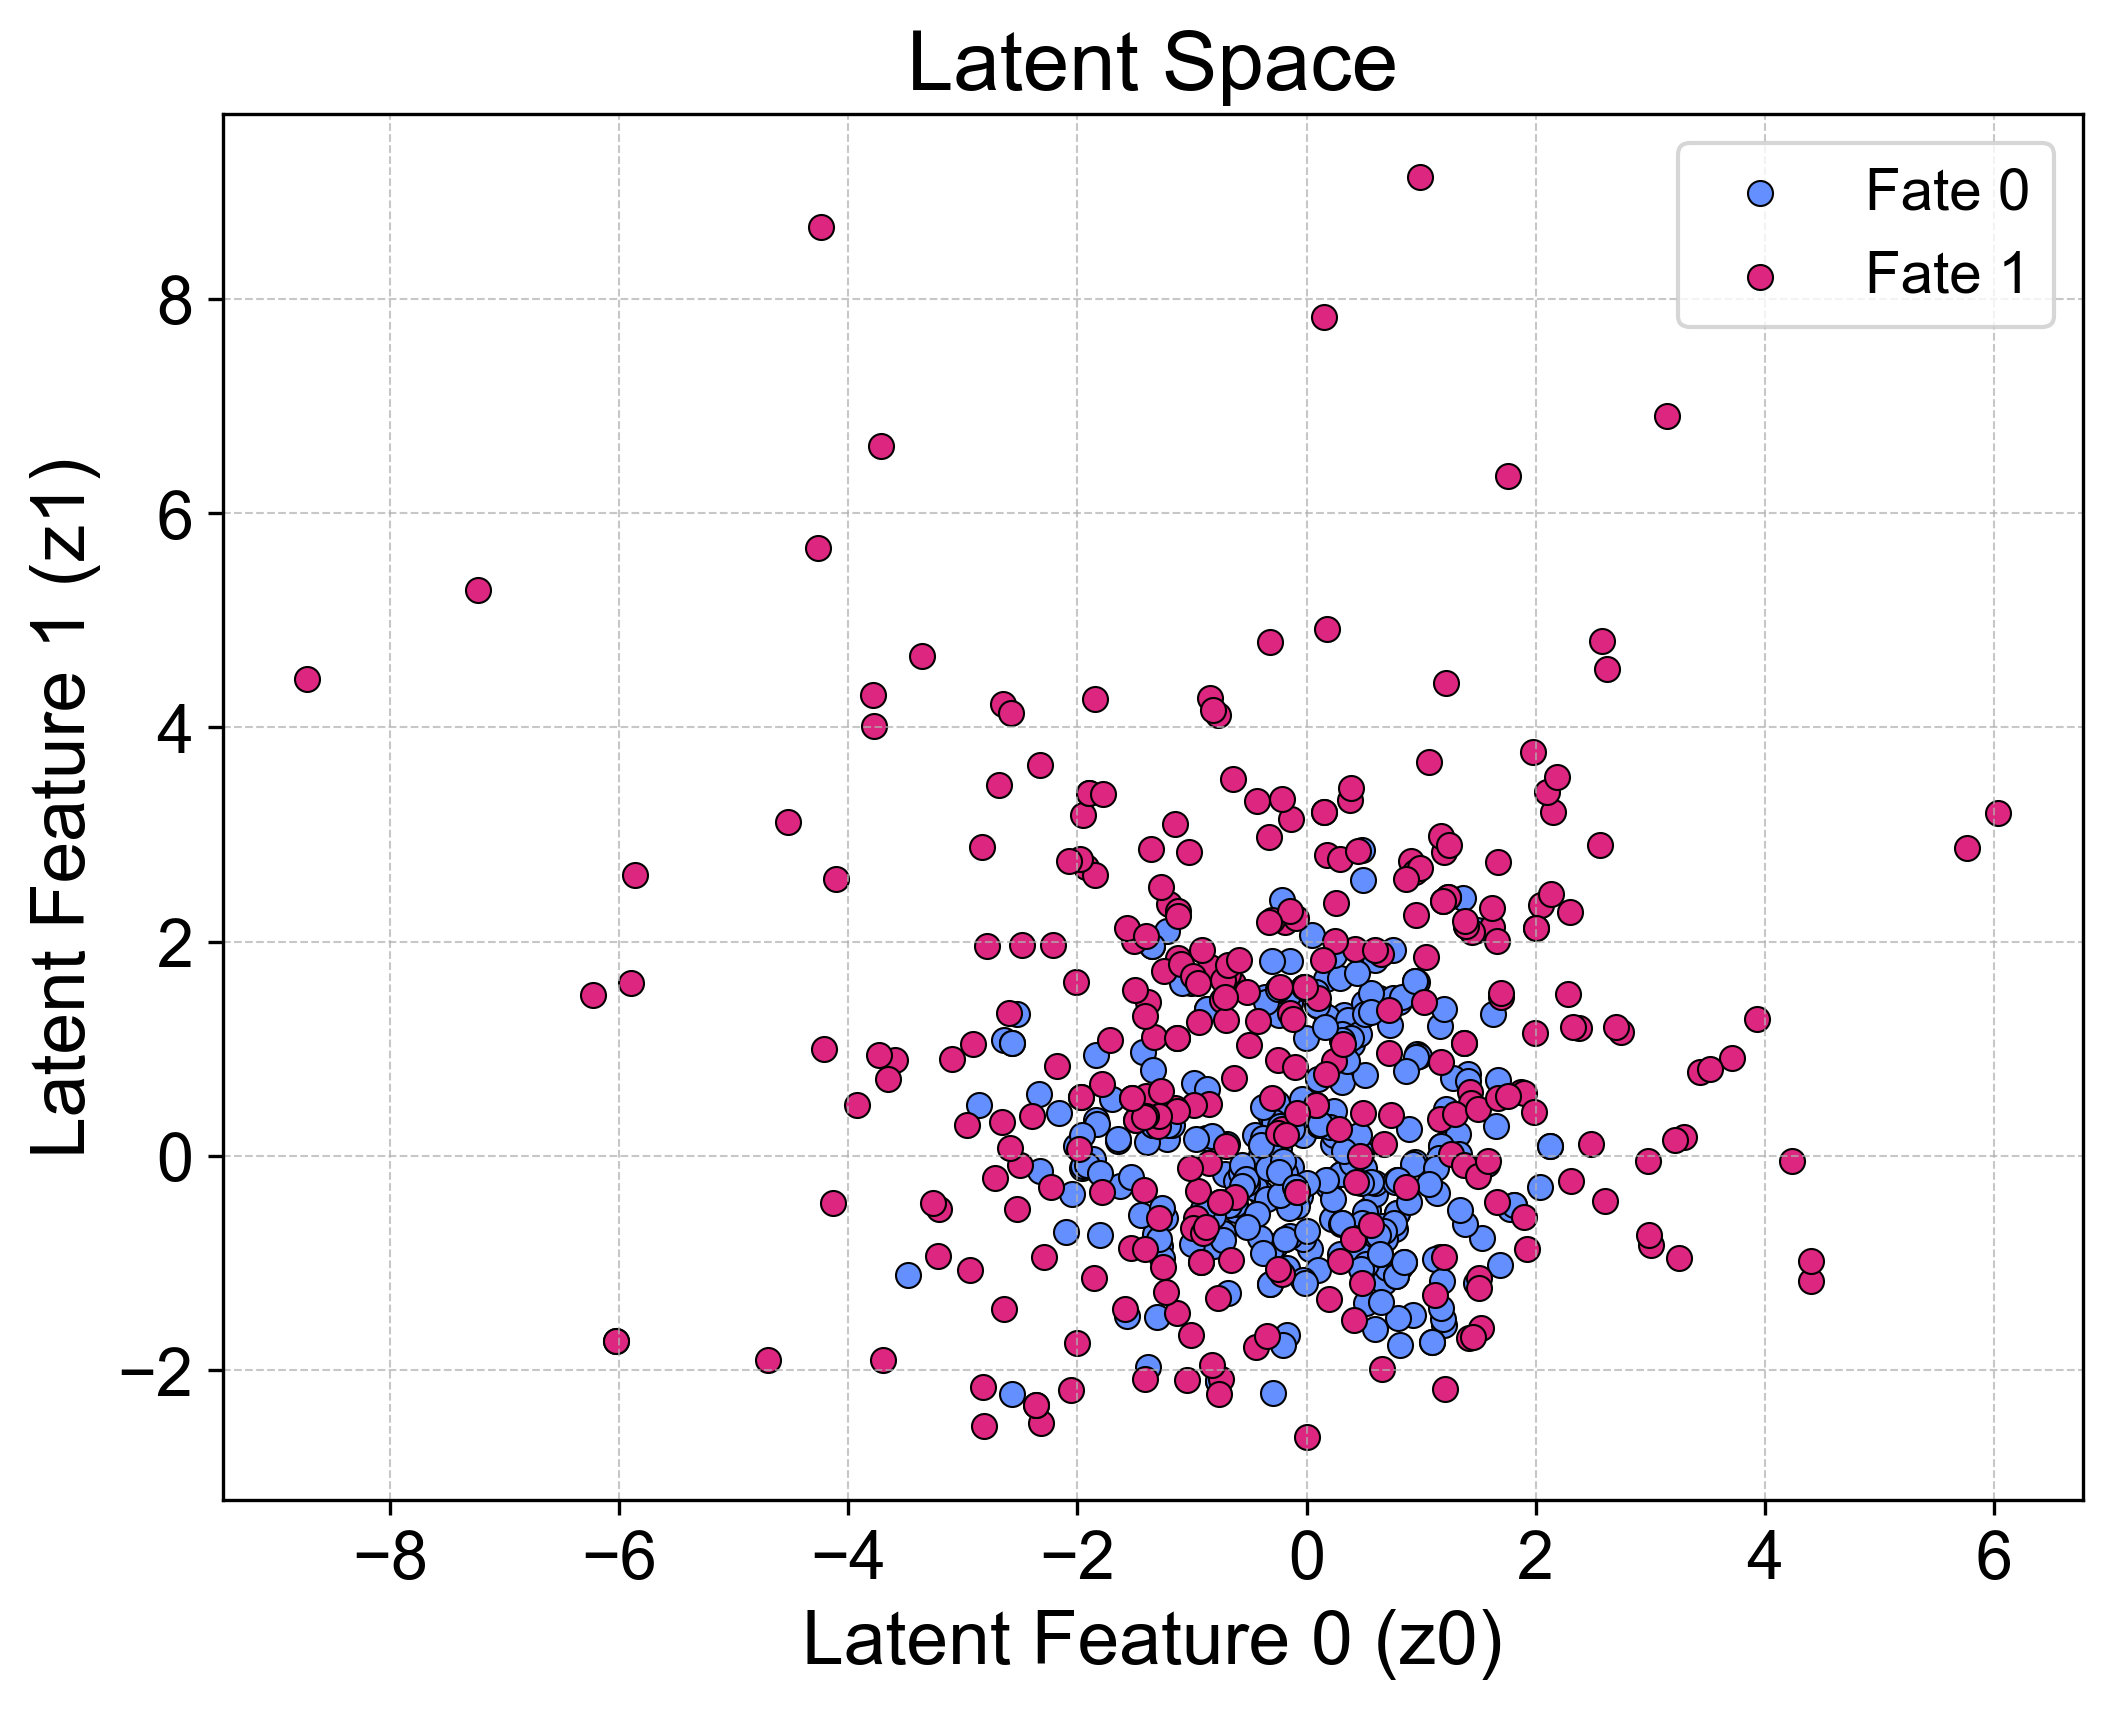

In [ ]:
# Predict the latent representations
latent_2d = encoder.predict(x_train) 

# Find extreme points for axis limits
x_min, x_max = latent_2d[:, 0].min() - 0.5, latent_2d[:, 0].max() + 0.5
y_min, y_max = latent_2d[:, 1].min() - 0.5, latent_2d[:, 1].max() + 0.5

# Create the plot
plt.figure(figsize=(8, 6), dpi=300)

# Scatter plot for each class separately with thin gray edges
plt.scatter(latent_2d[y_train == 0][:, 0], latent_2d[y_train == 0][:, 1], 
            color='#648fff', label="Fate 0", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  
plt.scatter(latent_2d[y_train == 1][:, 0], latent_2d[y_train == 1][:, 1], 
            color='#dc267f', label="Fate 1", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  

# Set axis limits
# plt.xlim(-4, 4)
# plt.ylim(-4, 4)

# Make tick labels much bigger and set to Arial font
plt.tick_params(axis='both', which='major', labelsize=16)
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontname('Arial')

# Increase font size and set Arial font
plt.xlabel("Latent Feature 0 (z0)", fontsize=18, fontname="Arial")
plt.ylabel("Latent Feature 1 (z1)", fontsize=18, fontname="Arial")
plt.title("Latent Space", fontsize=20, fontname="Arial")

# Legend and grid
plt.legend(fontsize=14)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

#plt.savefig("brightfield_latent_space_not_engineered.eps", format="eps", dpi=600, bbox_inches="tight")
plt.show()

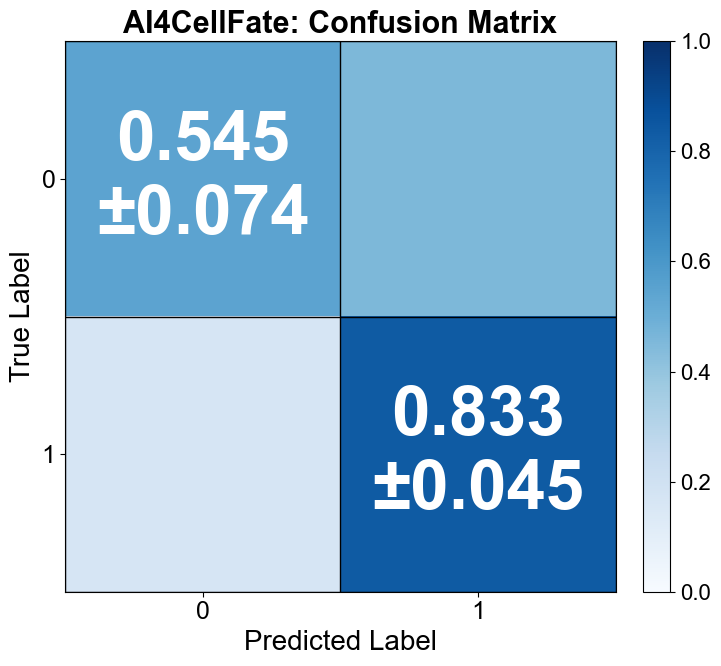

In [ ]:
ai4cellfate_seed42 = np.load("/Users/inescunha/Desktop/AI4CellFate/Rebuttal2/ablation_study/s1_ep100_lr5_la1_seed42_ldim2_s2_lr6_la2_lc0.0_lcon0.0_frame1/confusion_matrix_values_epoch_63.npy")
ai4cellfate_seed43 = np.load("/Users/inescunha/Desktop/AI4CellFate/Rebuttal2/ablation_study/s1_ep100_lr5_la1_seed43_ldim2_s2_lr6_la2_lc0.0_lcon0.0_frame1/confusion_matrix_values_epoch_62.npy")
ai4cellfate_seed44 = np.load("/Users/inescunha/Desktop/AI4CellFate/Rebuttal2/ablation_study/s1_ep100_lr5_la1_seed44_ldim2_s2_lr6_la2_lc0.0_lcon0.0_frame1/confusion_matrix_values_epoch_60.npy")

conf_matrix_ai4cellfate = np.stack([ai4cellfate_seed42, ai4cellfate_seed43, ai4cellfate_seed44], axis=0)

# Compute mean and std across seeds
mean_cm = np.mean(conf_matrix_ai4cellfate, axis=0)
std_cm = np.std(conf_matrix_ai4cellfate, axis=0)

# Use Arial and larger fonts
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 18

fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(mean_cm, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)

# Title and labels
ax.set_title('AI4CellFate: Confusion Matrix', fontsize=22, fontweight='bold')
num_classes = mean_cm.shape[0]
ax.set_xlabel('Predicted Label', fontsize=20)
ax.set_ylabel('True Label', fontsize=20)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels([str(i) for i in range(num_classes)], fontsize=18)
ax.set_yticklabels([str(i) for i in range(num_classes)], fontsize=18)

# Grid lines for clarity
ax.set_xticks(np.arange(-0.5, num_classes, 1), minor=True)
ax.set_yticks(np.arange(-0.5, num_classes, 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
ax.tick_params(which='minor', bottom=False, left=False)

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=16)

# Annotate ONLY diagonal cells with mean ± std in WHITE
for i in range(num_classes):
    for j in range(num_classes):
        if i == j:  # Only show values on the diagonal
            text = f"{mean_cm[i, j]:.3f}\n±{std_cm[i, j]:.3f}"
            ax.text(j, i, text, ha='center', va='center', color='white', fontsize=50, fontweight='bold')

plt.tight_layout()
#plt.savefig("brightfield_conf_matrix_not_engineered.eps", dpi=300, bbox_inches="tight")
plt.show()